# Mohammad Amin Kiani 4003613052

## Import DataSets:

In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths in Google Drive
normal_data_path = '/content/drive/My Drive/ptbdb_normal.csv'
abnormal_data_path = '/content/drive/My Drive/ptbdb_abnormal.csv'

# Load data
normal_data = pd.read_csv(normal_data_path, header=None)
abnormal_data = pd.read_csv(abnormal_data_path, header=None)

# Check data loaded
print("Normal data shape:", normal_data.shape)
print("Abnormal data shape:", abnormal_data.shape)

#------------------------------------------------------------------------------
print("----------------------------------------------------------------------")

# Load data
train_data = pd.read_csv('/content/drive/My Drive/mitbih_train.csv', header=None)
test_data = pd.read_csv('/content/drive/My Drive/mitbih_test.csv', header=None)

# Check data loaded
print("train data shape:", train_data.shape)
print("test data shape:", test_data.shape)


Mounted at /content/drive
Normal data shape: (4046, 188)
Abnormal data shape: (10506, 188)
----------------------------------------------------------------------
train data shape: (87554, 188)
test data shape: (21892, 188)


# 2 Class - abN or N?

✔️ No overlap between training and test sets.

Class distribution in Training set: 
Class 0: 2867 samples
Class 1: 7314 samples

Class distribution in Test set: 
Class 0: 1178 samples
Class 1: 3186 samples

✔️ Class distribution between Train and Test sets is similar.
Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - accuracy: 0.7094 - loss: 0.5830 - val_accuracy: 0.6900 - val_loss: 0.5722 - learning_rate: 5.0000e-04
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7376 - loss: 0.5233 - val_accuracy: 0.7807 - val_loss: 0.4656 - learning_rate: 5.0000e-04
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7681 - loss: 0.4910 - val_accuracy: 0.7802 - val_loss: 0.4460 - learning_rate: 5.0000e-04
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7829 - loss: 0.4662 - val_accuracy: 0.7764 - val_loss: 0.4472 - learning_rate: 5.0000e-04
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7889 - loss: 0.4495 - val_accura

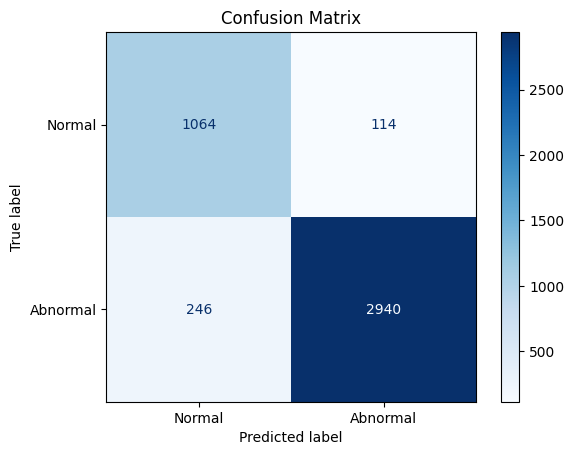

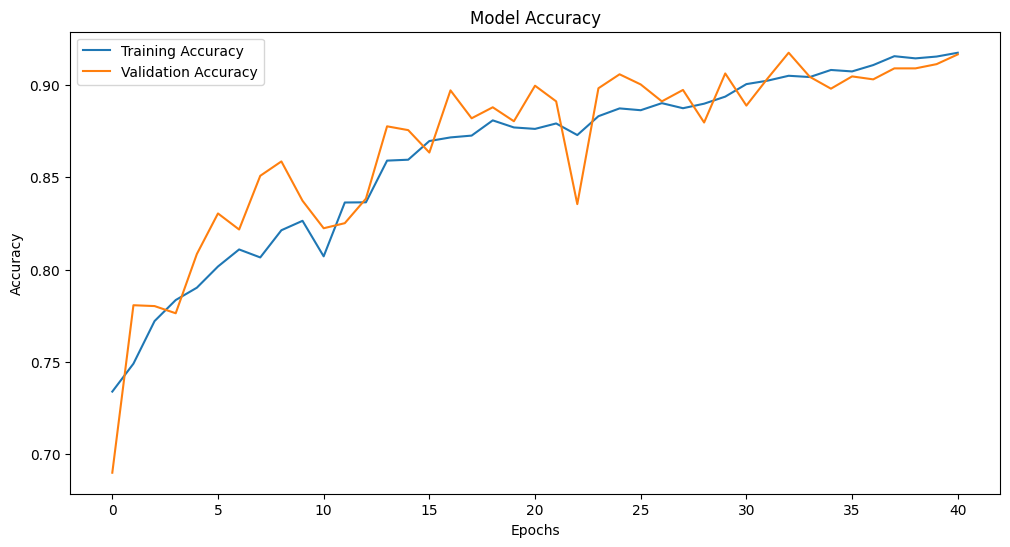

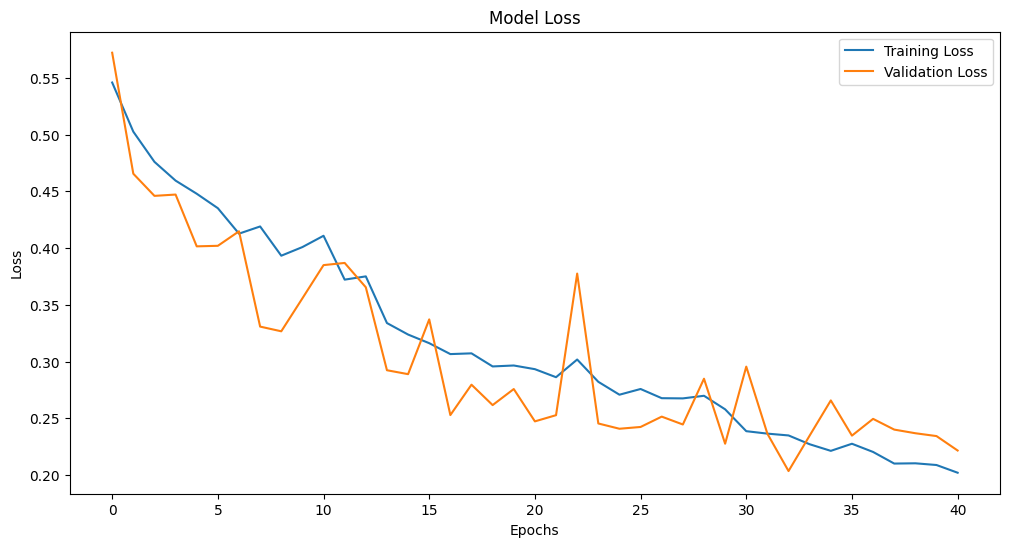

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])


# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Remove duplicate samples & Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True).drop_duplicates()

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Define a function to check for overlap
def check_overlap(X_train, X_test, y_train, y_test):
    train_flat = set(map(tuple, X_train))
    test_flat = set(map(tuple, X_test))
    overlap = train_flat.intersection(test_flat)

    if overlap:
        print(f"Warning: {len(overlap)} overlapping samples between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")

    print("\nClass distribution in Training set: ")
    for cls, count in zip(*np.unique(y_train, return_counts=True)):
        print(f"Class {cls}: {count} samples")

    print("\nClass distribution in Test set: ")
    for cls, count in zip(*np.unique(y_test, return_counts=True)):
        print(f"Class {cls}: {count} samples")


    train_classes, train_counts = np.unique(y_train, return_counts=True)
    test_classes, test_counts = np.unique(y_test, return_counts=True)

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")


# Define a function to split data by time and avoid overlap
def split_data_temporally(X, y, train_ratio=0.7):
    train_size = int(len(X) * train_ratio)
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

X_train, X_test, y_train, y_test = split_data_temporally(X, y)

# Normalize data separately for training and testing
# scaler = MinMaxScaler()
# RobustScaler: این روش با استفاده از میانه و بازه بین چهارک‌ها داده‌ها را نرمال و نسبت به مقادیر پرت مقاوم‌تر است
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Fourier Transform (optional)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Add noise to training data (optional)
def add_noise(data, noise_level=0.05):
    return data + noise_level * np.random.normal(size=data.shape)

X_train = add_noise(X_train, noise_level=0.05)

# Check for overlap
check_overlap(X_train, X_test, y_train, y_test)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define Transformer Encoder Block
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(ff_dim // 2)
        ])
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.num_heads = num_heads

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        mask = tf.reduce_sum(tf.abs(inputs), axis=-1, keepdims=True)
        mask = tf.cast(tf.not_equal(mask, 0), dtype=tf.float32)
        mask = tf.tile(mask, [1, 1, self.num_heads])
        mask = tf.reshape(mask, (-1, self.num_heads, seq_len, 1))
        mask = tf.tile(mask, [1, 1, 1, seq_len])

        attn_output = self.mha(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

# Build Transformer-based Model
def build_transformer_model(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = TransformerEncoderLayer(num_heads=4, ff_dim=256)(x)
    x = TransformerEncoderLayer(num_heads=4, ff_dim=256)(x)
    x = TransformerEncoderLayer(num_heads=4, ff_dim=256)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# compile model
model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
], verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report and confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Model Loss")
plt.show()


# 5 Class - 0 1 2 3 4

No overlap detected between training and testing sets.
Epoch 1/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.3373 - loss: 1.2740 - val_accuracy: 0.5046 - val_loss: 1.0838 - learning_rate: 0.0010
Epoch 2/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4499 - loss: 0.9809 - val_accuracy: 0.5740 - val_loss: 0.9704 - learning_rate: 0.0010
Epoch 3/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5503 - loss: 0.8854 - val_accuracy: 0.6632 - val_loss: 0.9019 - learning_rate: 0.0010
Epoch 4/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5740 - loss: 0.8500 - val_accuracy: 0.5345 - val_loss: 1.2417 - learning_rate: 0.0010
Epoch 5/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5563 - loss: 0.8626 - val_accuracy: 0.4909 - val_loss: 1.3188 - learning_rate: 0.0010
Epoch 6/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5815 - loss: 0.8252 - val_accuracy: 0.6289 - val_loss: 0.9507 - learning_rate: 0.0010
Epoch 7/50
685/685 ━━━━

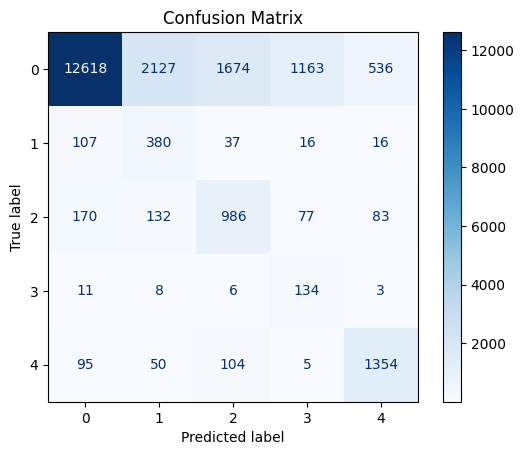

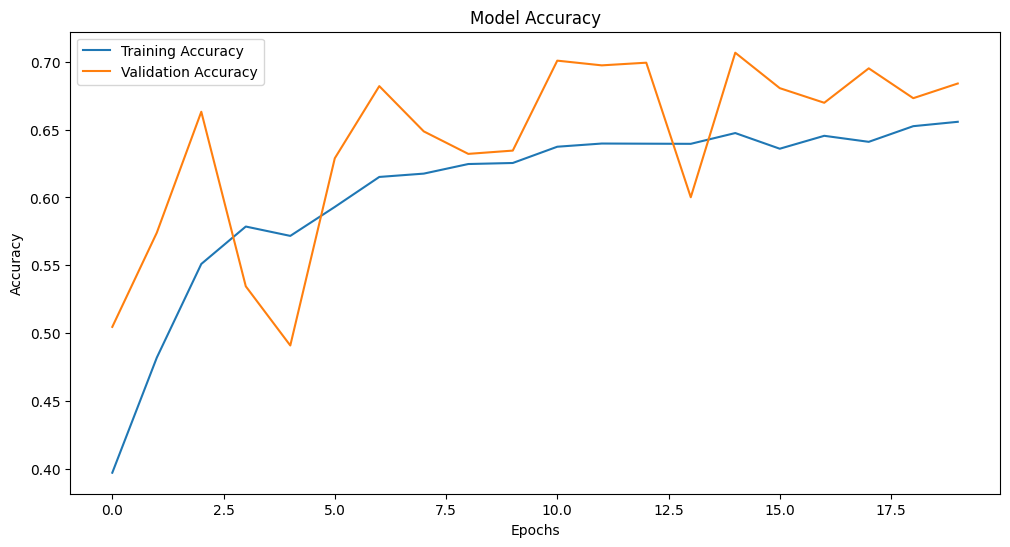

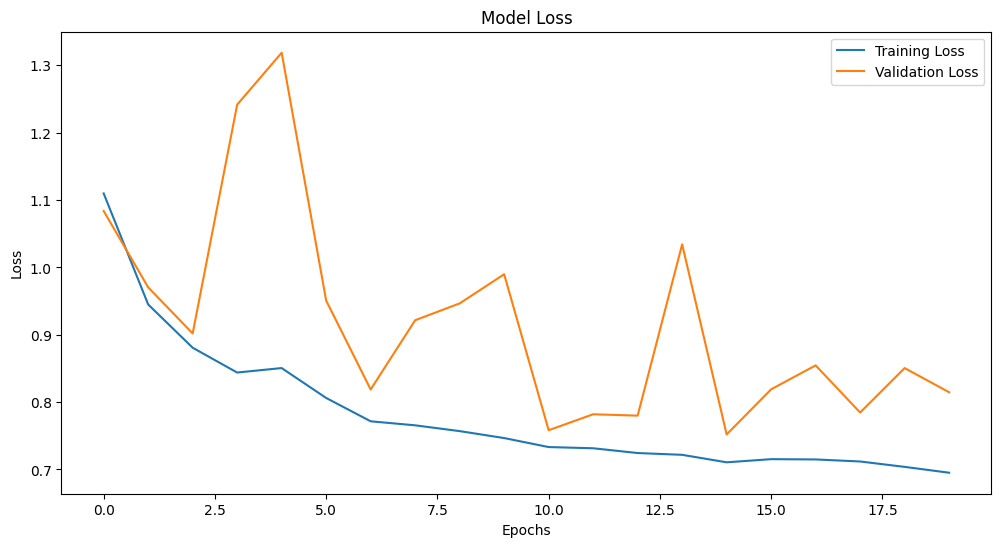

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load data
train_data = pd.read_csv('/content/drive/My Drive/mitbih_train.csv', header=None)
test_data = pd.read_csv('/content/drive/My Drive/mitbih_test.csv', header=None)

# Separate features and labels
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Clean labels
def clean_labels(features, labels):
    valid_indices = ~np.isnan(labels)
    features = features[valid_indices]
    labels = labels[valid_indices].astype(int)
    return features, labels

X_train, y_train = clean_labels(X_train, y_train)
X_test, y_test = clean_labels(X_test, y_test)

# Normalize data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Apply Fourier Transform
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Reshape data for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Check overlap
def check_overlap(X_train, X_test):
    train_flat = set(map(tuple, X_train.reshape(X_train.shape[0], -1)))
    test_flat = set(map(tuple, X_test.reshape(X_test.shape[0], -1)))
    overlap = train_flat.intersection(test_flat)
    if overlap:
        print(f"Warning: {len(overlap)} overlapping samples detected between training and testing sets.")
    else:
        print("No overlap detected between training and testing sets.")

check_overlap(X_train, X_test)

# Define Transformer Encoder Layer
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=1)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        mask = tf.reduce_sum(tf.abs(inputs), axis=-1, keepdims=True)
        mask = tf.cast(tf.not_equal(mask, 0), dtype=tf.float32)

        attn_output = self.attention(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer-based Model
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = TransformerEncoderLayer(num_heads=2, ff_dim=128)(x)
x = TransformerEncoderLayer(num_heads=2, ff_dim=128)(x)
x = TransformerEncoderLayer(num_heads=2, ff_dim=128)(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)

model_transformer = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Compile and train model
model_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate model
loss_transformer, accuracy_transformer = model_transformer.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy_transformer * 100:.2f}%')

# Classification report
y_pred_transformer = model_transformer.predict(X_test)
y_pred_classes = np.argmax(y_pred_transformer, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, zero_division=1))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Accuracy and Loss plots
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Epoch 1/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.8693 - loss: 0.4531 - val_accuracy: 0.9123 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 2/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9115 - loss: 0.2840 - val_accuracy: 0.9083 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 3/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9184 - loss: 0.2670 - val_accuracy: 0.9266 - val_loss: 0.2353 - learning_rate: 0.0010
Epoch 4/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9283 - loss: 0.2321 - val_accuracy: 0.9366 - val_loss: 0.2148 - learning_rate: 0.0010
Epoch 5/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9321 - loss: 0.2222 - val_accuracy: 0.9230 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 6/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9344 - loss: 0.2117 - val_accuracy: 0.9233 - val_loss: 0.2781 - learning_rate: 0.0010
Epoch 7/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9243 - l

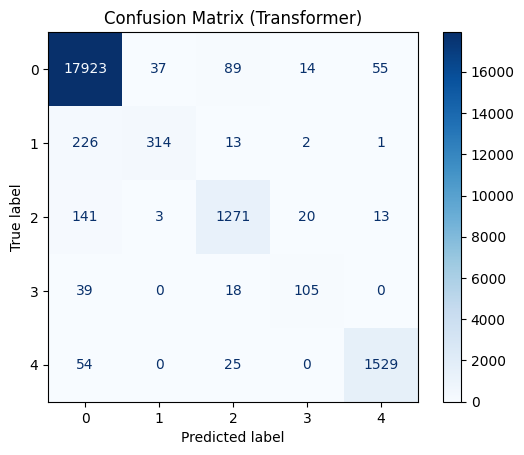

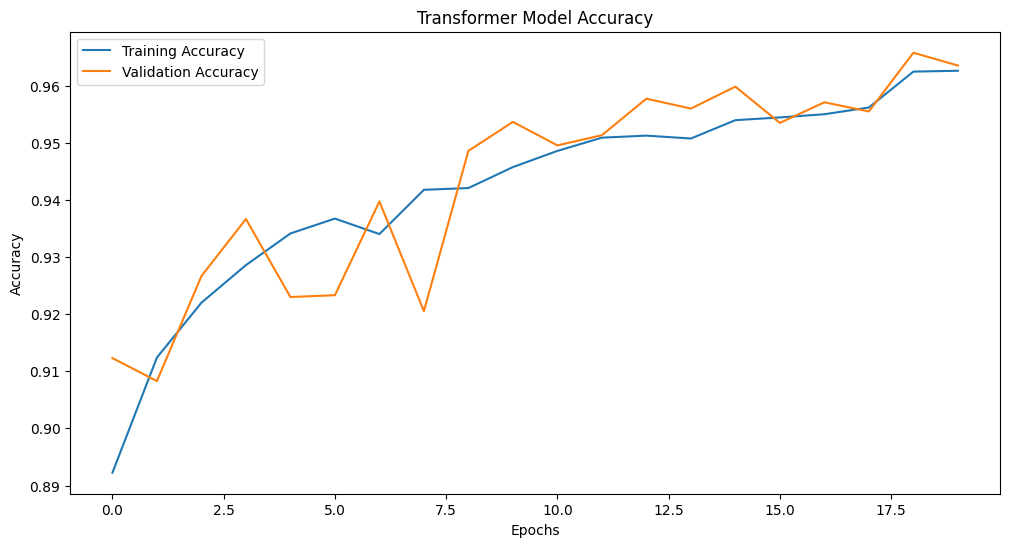

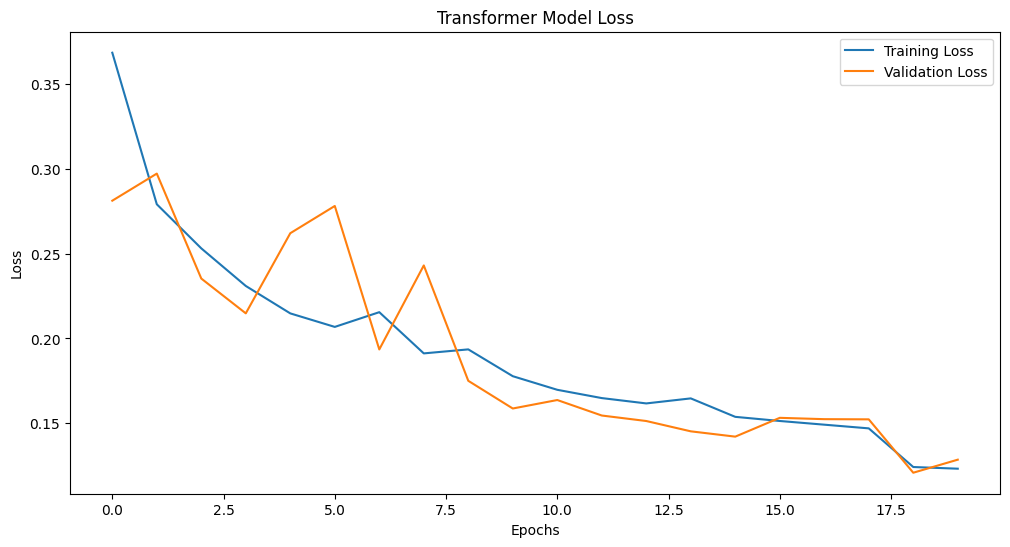

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Load data
train_data = pd.read_csv('/content/drive/My Drive/mitbih_train.csv', header=None)
test_data = pd.read_csv('/content/drive/My Drive/mitbih_test.csv', header=None)

# Separate features and labels
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values  # Labels are in the last column
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Check for invalid or missing labels
def clean_labels(features, labels):
    """Ensure all features and labels have matching lengths and valid data."""
    valid_indices = ~np.isnan(labels)  # Remove NaN values
    features = features[valid_indices]
    labels = labels[valid_indices].astype(int)  # Convert to integers
    return features, labels

X_train, y_train = clean_labels(X_train, y_train)
X_test, y_test = clean_labels(X_test, y_test)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels for multi-class classification
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Apply Fourier Transform (optional for feature extraction)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ff)

# Build Transformer-based Model
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = transformer_encoder(x, num_heads=2, ff_dim=128)
x = transformer_encoder(x, num_heads=2, ff_dim=128)
x = transformer_encoder(x, num_heads=2, ff_dim=128)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)

model_transformer = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Evaluate model
loss_transformer, accuracy_transformer = model_transformer.evaluate(X_test, y_test)
print(f'Test Accuracy with Transformer: {accuracy_transformer * 100:.2f}%')

# Predictions and confusion matrix
y_pred_transformer = model_transformer.predict(X_test)
y_pred_classes = np.argmax(y_pred_transformer, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report (Transformer):")
print(classification_report(y_true_classes, y_pred_classes))
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
unique_classes = np.unique(np.concatenate((y_true_classes, y_pred_classes)))  # Dynamically determine unique classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Transformer)")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Transformer Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transformer Model Loss')
plt.show()


# Temps - Other Model


Class distribution in Training set:
Class 0: 2832 samples
Class 1: 7354 samples

Class distribution in Test set:
Class 0: 1214 samples
Class 1: 3152 samples

✔️ Class distribution between Train and Test sets is similar.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5969 - loss: 4.7605 - val_accuracy: 0.7219 - val_loss: 3.4007 - learning_rate: 5.0000e-04
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7113 - loss: 3.0385 - val_accuracy: 0.7034 - val_loss: 2.3604 - learning_rate: 5.0000e-04
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7705 - loss: 2.0222 - val_accuracy: 0.7219 - val_loss: 1.7409 - learning_rate: 5.0000e-04
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8585 - loss: 1.3333 - val_accuracy: 0.7219 - val_loss: 1.3455 - learning_rate: 5.0000e-04
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8604 - loss: 0.9840 - val_accuracy: 0.7224 - val_loss: 1.0618 - learning_rate: 5.0000e-04
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8740 - loss: 0.7550 - val_accuracy: 0.7730 - val_loss: 0.7450 - learning_rate: 5.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - ac

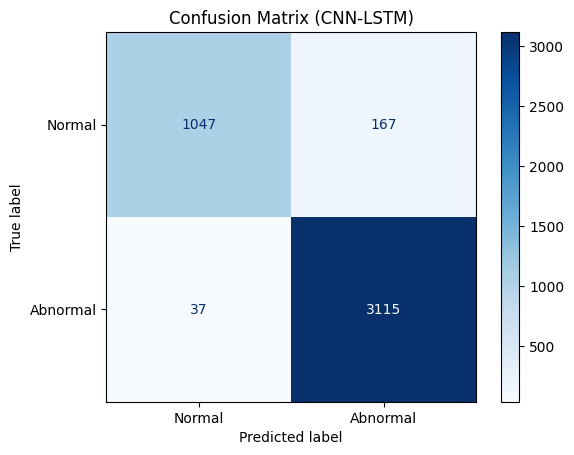

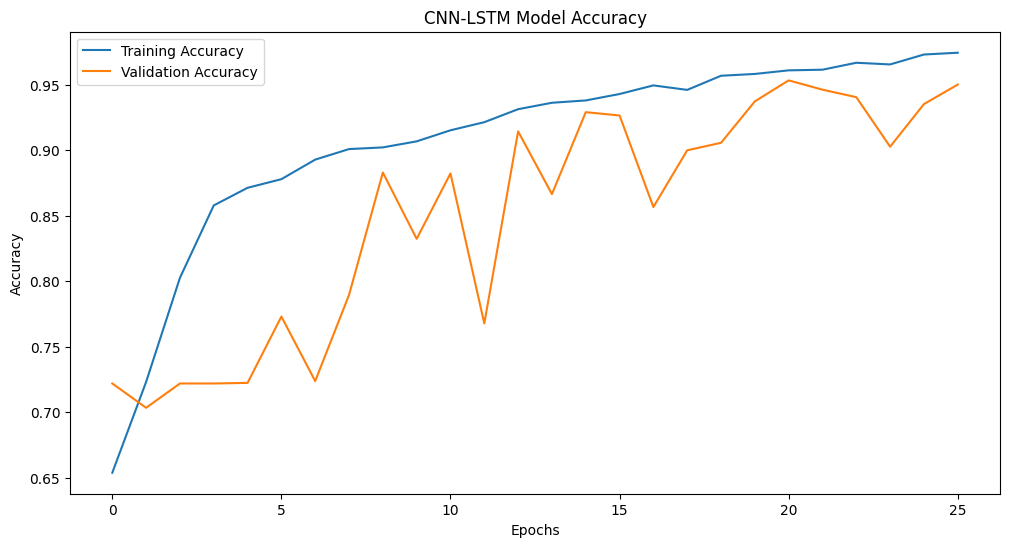

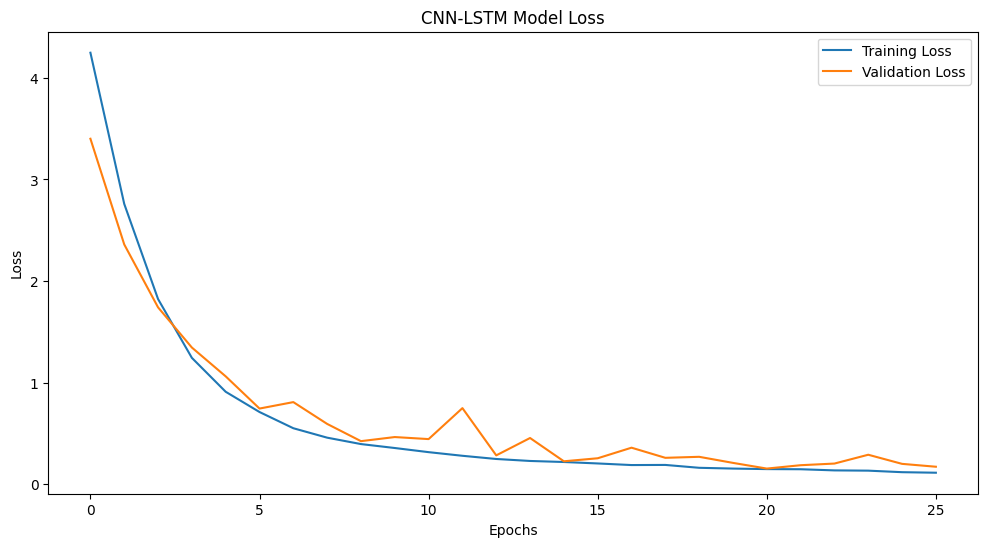

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to check data split
def check_data_split(X_train, X_test, y_train, y_test):
    intersection = np.intersect1d(X_train.flatten(), X_test.flatten())
    if len(intersection) > 0:
        print("Warning: There is overlap between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")

    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")

# # Load data
# normal_data = pd.read_csv('ptbdb_normal.csv', header=None)
# abnormal_data = pd.read_csv('ptbdb_abnormal.csv', header=None)

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
check_data_split(X_train, X_test, y_train, y_test)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN-LSTM model
model_cnn_lstm = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Evaluate model
loss_cnn_lstm, accuracy_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test)
print(f'Test Accuracy with CNN-LSTM: {accuracy_cnn_lstm * 100:.2f}%')

# Predictions and confusion matrix
y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test) > 0.5).astype(int)
print("\nClassification Report (CNN-LSTM):")
print(classification_report(y_test, y_pred_cnn_lstm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CNN-LSTM)")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN-LSTM Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN-LSTM Model Loss')
plt.show()



Class distribution in Training set:
Class 0: 2832 samples
Class 1: 7354 samples

Class distribution in Test set:
Class 0: 1214 samples
Class 1: 3152 samples

✔️ Class distribution between Train and Test sets is similar.

Class distribution in Training set:
Class 0: 2832 samples
Class 1: 7354 samples

Class distribution in Test set:
Class 0: 1214 samples
Class 1: 3152 samples
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6242 - loss: 3.2368 - val_accuracy: 0.7219 - val_loss: 2.1504 - learning_rate: 5.0000e-04
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7029 - loss: 1.9500 - val_accuracy: 0.7215 - val_loss: 1.4600 - learning_rate: 5.0000e-04
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7251 - loss: 1.3556 - val_accuracy: 0.3809 - val_loss: 1.3039 - learning_rate: 5.0000e-04
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7199 - loss: 1.0629 - val_accuracy: 0.7203 - val_loss: 0.9395 - learning_rate: 5.0000e-04
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7346 - loss: 0.8823 - val_accuracy: 0.7350 - val_loss: 0.8161 - learning_rate: 5.0000e-04
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7293 - loss: 0.7614 - val_accuracy: 0.6138 - val_loss: 0.8047 - learning_rate: 5.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.

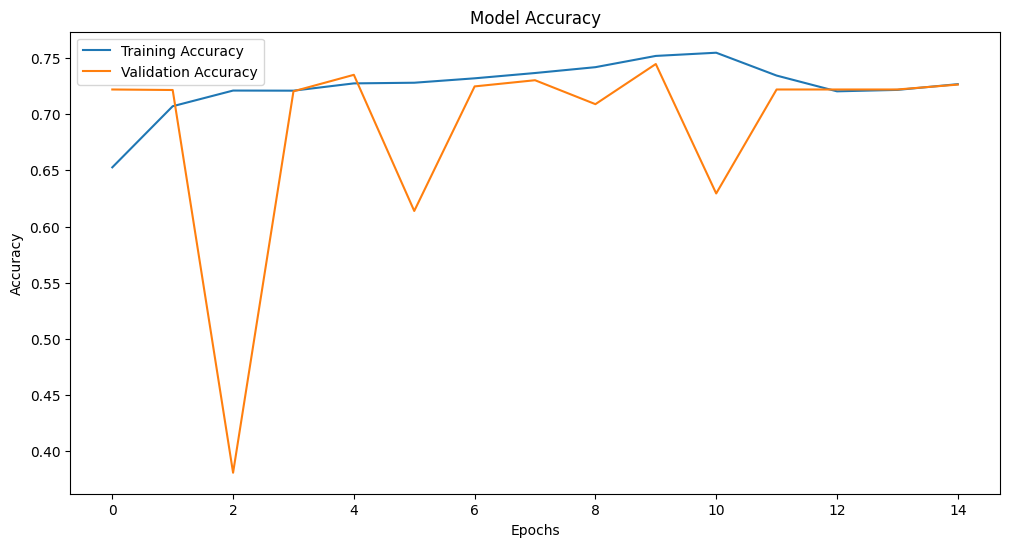

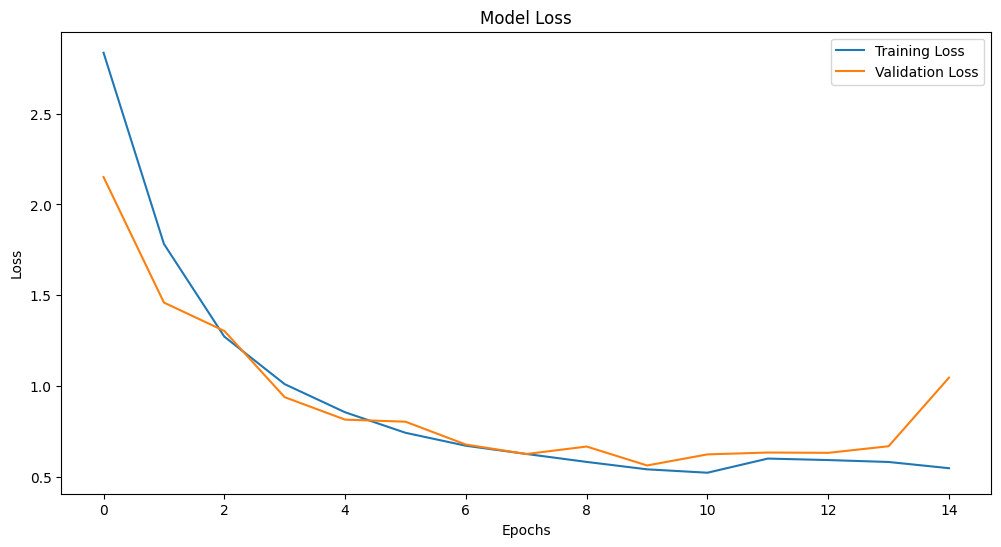

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# بررسی درست تقسیم شدن داده‌ها
def check_data_split(X_train, X_test, y_train, y_test):
    # 1. بررسی همپوشانی داده‌ها
    intersection = np.intersect1d(X_train.flatten(), X_test.flatten())
    if len(intersection) > 0:
        print("Warning: There is overlap between training and test sets!")
    else:
        print("✔️ No overlap between training and test sets.")

    # 2. بررسی تعادل کلاس‌ها در داده‌های آموزش
    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    # 3. بررسی تعادل کلاس‌ها در داده‌های تست
    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    # 4. بررسی مشابهت توزیع کلاس‌ها بین Train و Test
    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):  # تفاوت تا 5%
        print("\n✔️ Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")
        print("Training distribution:", train_distribution)
        print("Test distribution:", test_distribution)

# # 1. بارگذاری داده‌ها
# normal_data = pd.read_csv('ptbdb_normal.csv', header=None)
# abnormal_data = pd.read_csv('ptbdb_abnormal.csv', header=None)

# حذف ستون آخر از فایل normal_data
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])

# حذف ستون آخر از فایل abnormal_data
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# 2. افزودن برچسب‌ها
normal_data['label'] = 0  # برچسب 0 برای Normal
abnormal_data['label'] = 1  # برچسب 1 برای Abnormal

# 3. ترکیب داده‌ها
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# 4. جدا کردن ویژگی‌ها و برچسب‌ها
X = data.iloc[:, :-1].values  # سیگنال‌های ECG
y = data['label'].values      # برچسب‌ها

# 5. تقسیم داده‌ها به مجموعه‌های آموزش و تست بر اساس زمان
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
check_data_split(X_train, X_test, y_train, y_test)

# 6. نرمال‌سازی داده‌ها
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7. تغییر شکل داده‌ها برای LSTM (حفظ بعدهای زمانی)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. بررسی توزیع کلاس‌ها در داده‌های آموزش و تست
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

print("\nClass distribution in Training set:")
for cls, count in zip(train_classes, train_counts):
    print(f"Class {cls}: {count} samples")

print("\nClass distribution in Test set:")
for cls, count in zip(test_classes, test_counts):
    print(f"Class {cls}: {count} samples")
# 9. تعریف مدل RNN تقویت‌شده
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),  # افزایش Dropout

    tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),  # Regularization

    tf.keras.layers.Dense(1, activation='sigmoid')  # طبقه‌بندی باینری
])

# 10. کامپایل و آموزش مدل
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # کاهش نرخ یادگیری
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=30,  # افزایش تعداد Epochها
    batch_size=64,  # افزایش Batch size
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),  # جلوگیری از overfitting
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # تنظیم نرخ یادگیری
    ]
)

# 11. ارزیابی مدل
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

from sklearn.metrics import classification_report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

# 12. رسم نمودار تغییرات دقت و خطا
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

✔️ No overlap between training and test sets.

Class distribution in Training set:
Class 0: 3264 samples
Class 1: 8372 samples

Class distribution in Test set:
Class 0: 781 samples
Class 1: 2128 samples

✔️ Class distribution between Train and Test sets is similar.
Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - accuracy: 0.6313 - loss: 0.6661 - val_accuracy: 0.7549 - val_loss: 0.4863 - learning_rate: 5.0000e-04
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.7305 - loss: 0.5532 - val_accuracy: 0.7659 - val_loss: 0.4685 - learning_rate: 5.0000e-04
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.7361 - loss: 0.5251 - val_accuracy: 0.7508 - val_loss: 0.4634 - learning_rate: 5.0000e-04
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.7488 - loss: 0.5027 - val_accuracy: 0.7735 - val_loss: 0.4554 - learning_rate: 5.0000e-04
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.7553 - loss: 0.5093 - val_accuracy

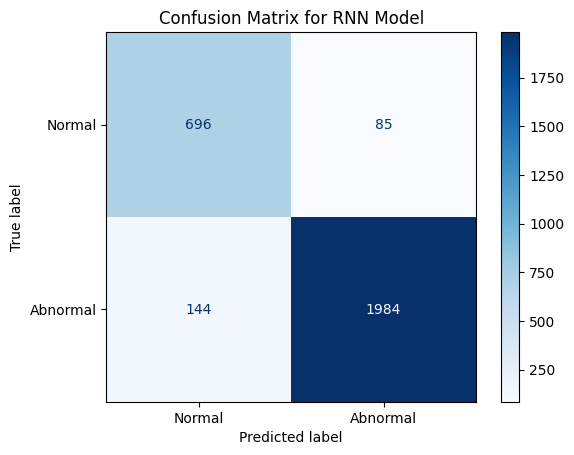

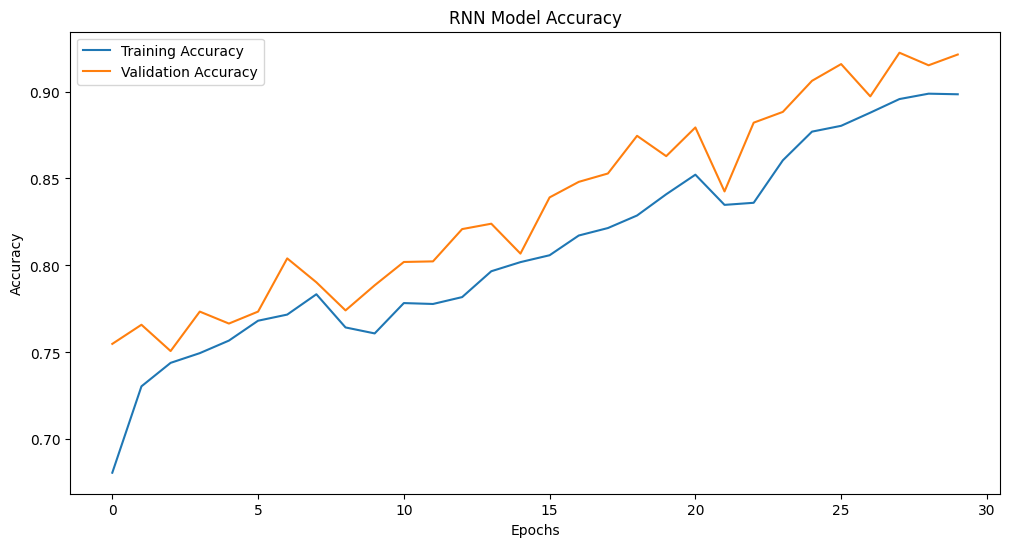

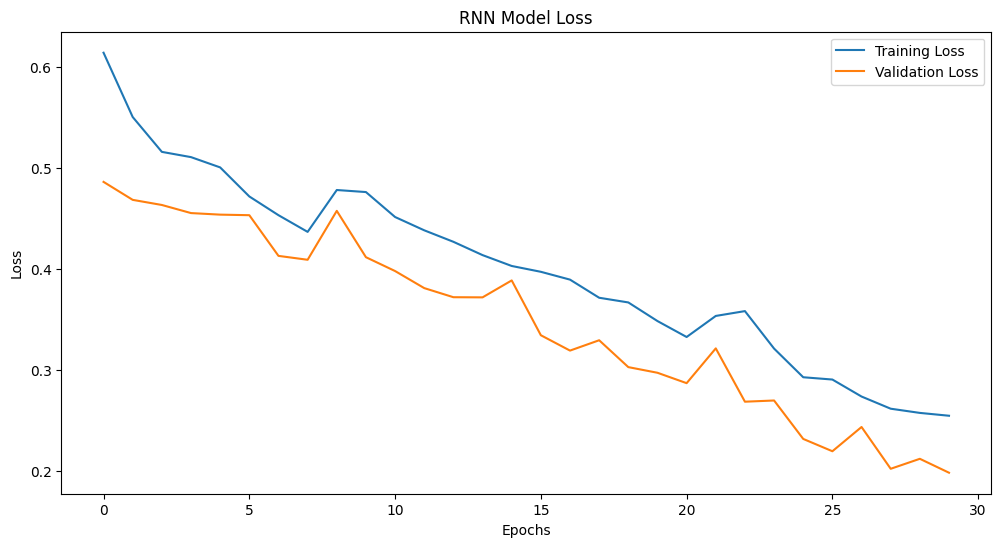

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# # Load Data (replace with your actual file paths)
# normal_data = pd.read_csv('/content/drive/My Drive/data/ptbdb_normal.csv', header=None)
# abnormal_data = pd.read_csv('/content/drive/My Drive/data/ptbdb_abnormal.csv', header=None)

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# Remove duplicate samples
data = data.drop_duplicates()

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Define a function to check for overlap
def check_overlap(X_train, X_test):
    train_flat = set(map(tuple, X_train))
    test_flat = set(map(tuple, X_test))
    overlap = train_flat.intersection(test_flat)
    if overlap:
        print(f"Warning: Found {len(overlap)} overlapping samples between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")

    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")

# Define a function to split data by time and avoid overlap
def split_data_temporally(X, y, train_ratio=0.8):
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

# Split data temporally
X_train, X_test, y_train, y_test = split_data_temporally(X, y)

# Normalize data separately for training and testing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Fourier Transform (optional)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Check for overlap
check_overlap(X_train, X_test)

# Add noise to training data (optional)
def add_noise(data, noise_level=0.05):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

X_train = add_noise(X_train, noise_level=0.05)

# Reshape for RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define RNN-based Model with SimpleRNN
def build_rnn_model(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.SimpleRNN(128, return_sequences=True)(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.SimpleRNN(64, return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.SimpleRNN(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Build and compile RNN model with SimpleRNN
rnn_model = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]))
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=1
)

# Evaluate RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"RNN Test Accuracy: {rnn_accuracy * 100:.2f}%")

# Classification report and confusion matrix for RNN model
rnn_y_pred = (rnn_model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report for RNN Model:")
print(classification_report(y_test, rnn_y_pred))

rnn_cm = confusion_matrix(y_test, rnn_y_pred)
rnn_disp = ConfusionMatrixDisplay(confusion_matrix=rnn_cm, display_labels=["Normal", "Abnormal"])
rnn_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RNN Model")
plt.show()

# Plot accuracy for RNN model
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('RNN Model Accuracy')
plt.show()

# Plot loss for RNN model
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Model Loss')
plt.show()


✔️ No overlap between training and test sets.

Class distribution in Training set:
Class 0: 3264 samples
Class 1: 8372 samples

Class distribution in Test set:
Class 0: 781 samples
Class 1: 2128 samples

✔️ Class distribution between Train and Test sets is similar.
Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5804 - loss: 0.7099 - val_accuracy: 0.7315 - val_loss: 0.5902 - learning_rate: 5.0000e-04
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7182 - loss: 0.5379 - val_accuracy: 0.7563 - val_loss: 0.4836 - learning_rate: 5.0000e-04
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7409 - loss: 0.5018 - val_accuracy: 0.7834 - val_loss: 0.4452 - learning_rate: 5.0000e-04
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7633 - loss: 0.4738 - val_accuracy: 0.8192 - val_loss: 0.3980 - learning_rate: 5.0000e-04
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7867 - loss: 0.4491 - val_accuracy: 0.

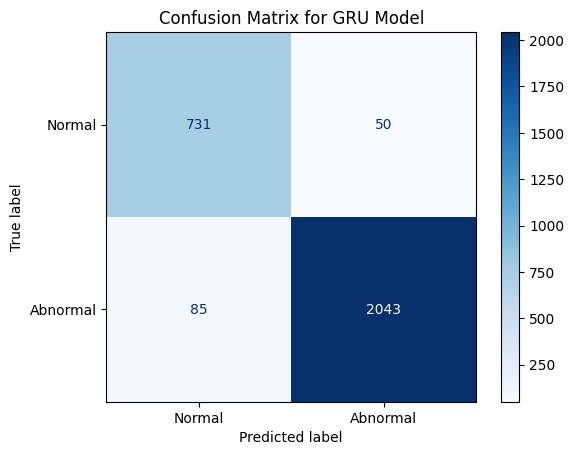

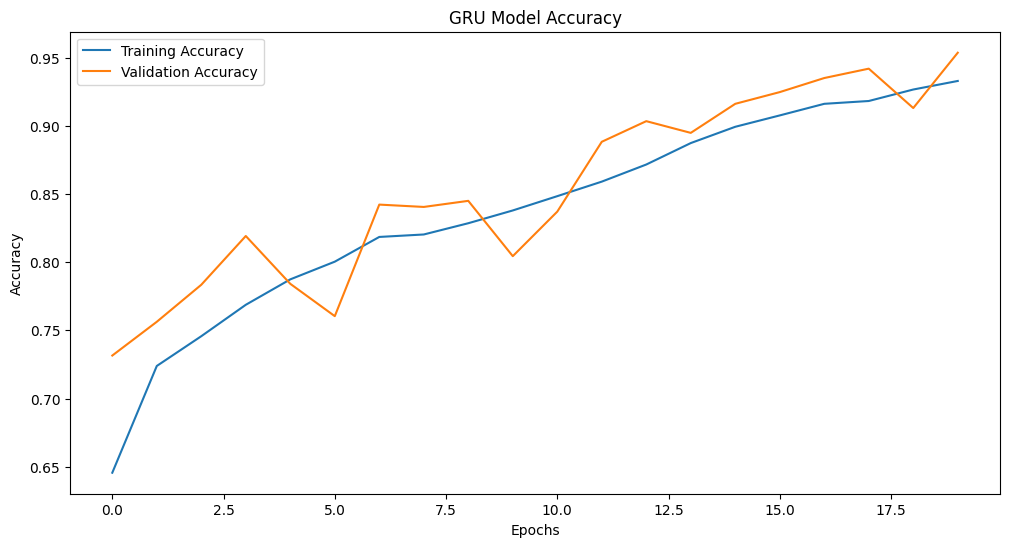

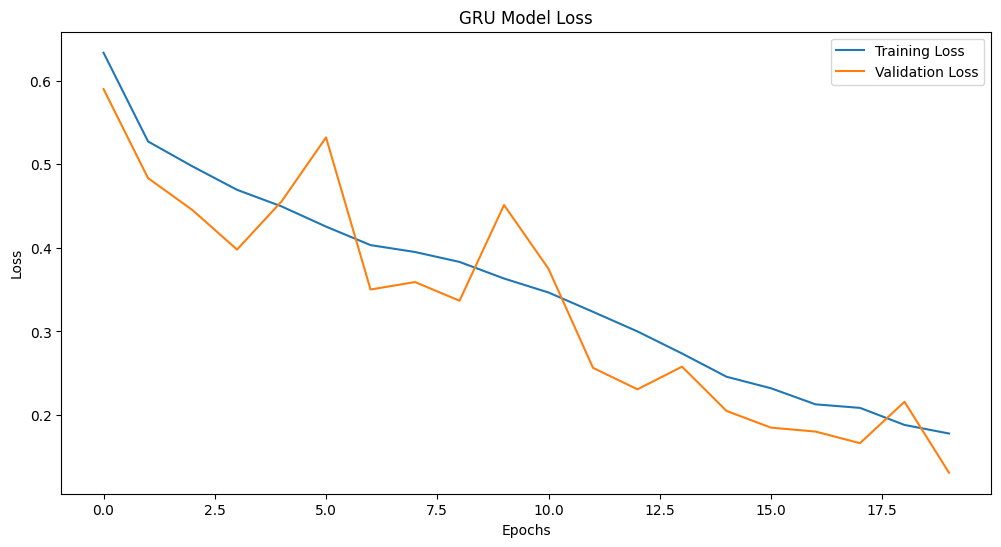

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# # Load Data (replace with your actual file paths)
# normal_data = pd.read_csv('/content/drive/My Drive/data/ptbdb_normal.csv', header=None)
# abnormal_data = pd.read_csv('/content/drive/My Drive/data/ptbdb_abnormal.csv', header=None)

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# Remove duplicate samples
data = data.drop_duplicates()

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Define a function to check for overlap
def check_overlap(X_train, X_test):
    train_flat = set(map(tuple, X_train))
    test_flat = set(map(tuple, X_test))
    overlap = train_flat.intersection(test_flat)
    if overlap:
        print(f"Warning: Found {len(overlap)} overlapping samples between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")

    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")

# Define a function to split data by time and avoid overlap
def split_data_temporally(X, y, train_ratio=0.8):
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

# Split data temporally
X_train, X_test, y_train, y_test = split_data_temporally(X, y)

# Normalize data separately for training and testing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Fourier Transform (optional)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Check for overlap
check_overlap(X_train, X_test)

# Add noise to training data (optional)
def add_noise(data, noise_level=0.05):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

X_train = add_noise(X_train, noise_level=0.05)

# Reshape for GRU input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define GRU-based Model
def build_gru_model(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.GRU(128, return_sequences=True)(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.GRU(64, return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.GRU(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Build and compile GRU model
gru_model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=1
)

# Evaluate GRU model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"GRU Test Accuracy: {gru_accuracy * 100:.2f}%")

# Classification report and confusion matrix for GRU model
gru_y_pred = (gru_model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report for GRU Model:")
print(classification_report(y_test, gru_y_pred))

gru_cm = confusion_matrix(y_test, gru_y_pred)
gru_disp = ConfusionMatrixDisplay(confusion_matrix=gru_cm, display_labels=["Normal", "Abnormal"])
gru_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for GRU Model")
plt.show()

# Plot accuracy for GRU model
plt.figure(figsize=(12, 6))
plt.plot(gru_history.history['accuracy'], label='Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('GRU Model Accuracy')
plt.show()

# Plot loss for GRU model
plt.figure(figsize=(12, 6))
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Model Loss')
plt.show()


Epoch 1/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.6937 - loss: 3.0568 - val_accuracy: 0.7336 - val_loss: 0.8876 - learning_rate: 0.0011
Epoch 2/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7427 - loss: 1.6673 - val_accuracy: 0.7640 - val_loss: 0.7087 - learning_rate: 0.0012
Epoch 3/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7733 - loss: 1.4222 - val_accuracy: 0.7520 - val_loss: 0.6611 - learning_rate: 0.0013
Epoch 4/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7969 - loss: 1.3313 - val_accuracy: 0.8023 - val_loss: 0.5799 - learning_rate: 0.0014
Epoch 5/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8091 - loss: 1.2852 - val_accuracy: 0.8706 - val_loss: 0.4123 - learning_rate: 0.0015
Epoch 6/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8268 - loss: 1.1727 - val_accuracy: 0.8271 - val_loss: 0.5683 - learning_rate: 0.0014
Epoch 7/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8443 - loss:

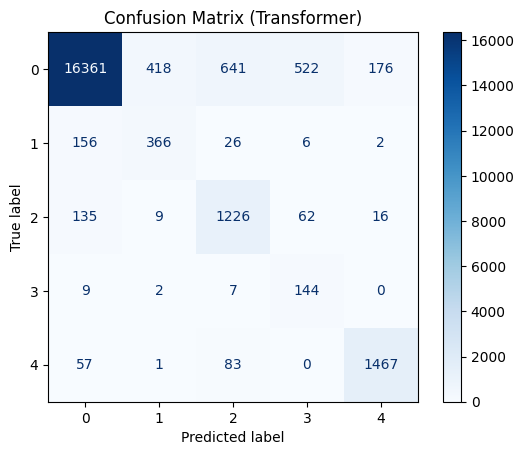

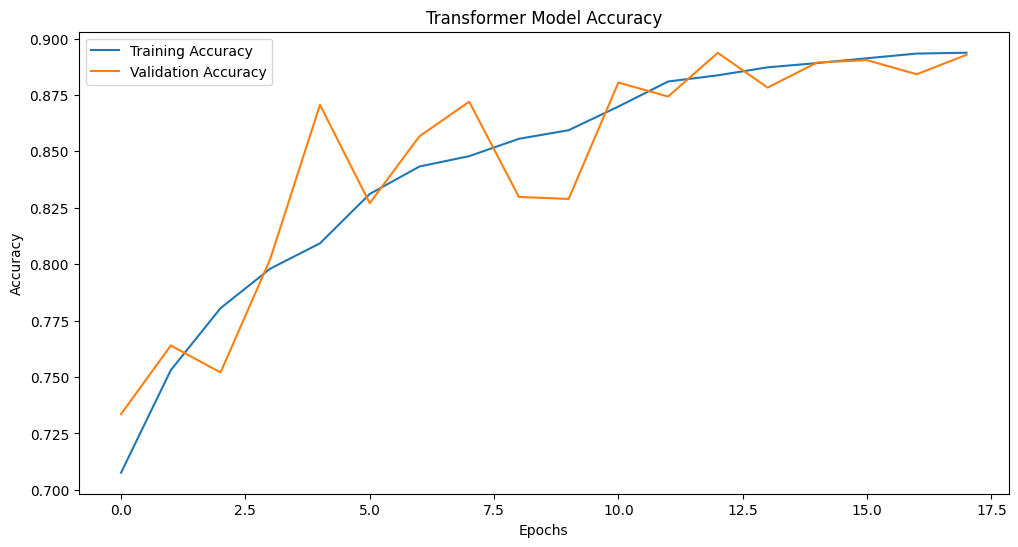

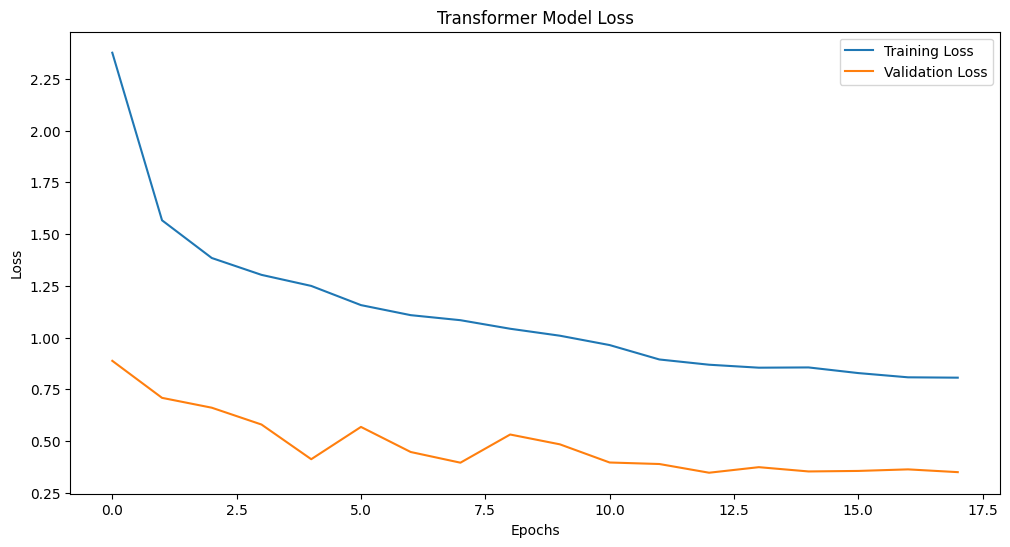

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# # Load data
# train_data = pd.read_csv('/content/drive/My Drive/mitbih_train.csv', header=None)
# test_data = pd.read_csv('/content/drive/My Drive/mitbih_test.csv', header=None)

# Separate features and labels
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values  # Labels are in the last column
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Clean labels
def clean_labels(features, labels):
    valid_indices = ~np.isnan(labels)  # Remove NaN values
    features = features[valid_indices]
    labels = labels[valid_indices].astype(int)  # Convert to integers
    return features, labels

X_train, y_train = clean_labels(X_train, y_train)
X_test, y_test = clean_labels(X_test, y_test)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Apply Fourier Transform
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Class weights
class_weights = {
    0: 1.0,
    1: 10.0,
    2: 5.0,
    3: 50.0,
    4: 1.0
}

# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.3):
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = tf.keras.layers.Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(attention)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ff)

# Build Transformer-based Model
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = transformer_encoder(x, num_heads=2, ff_dim=64, dropout=0.3)
x = transformer_encoder(x, num_heads=2, ff_dim=64, dropout=0.3)
x = transformer_encoder(x, num_heads=2, ff_dim=64, dropout=0.3)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)

model_transformer = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr + 0.0001)  # Ensure the output is float
    return float(lr * tf.math.exp(-0.1))  # Convert to float


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train model
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        lr_callback
    ]
)

# Evaluate model
loss_transformer, accuracy_transformer = model_transformer.evaluate(X_test, y_test)
print(f'Test Accuracy with Transformer: {accuracy_transformer * 100:.2f}%')

# Predictions and confusion matrix
y_pred_transformer = model_transformer.predict(X_test)
y_pred_classes = np.argmax(y_pred_transformer, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report (Transformer):")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
unique_classes = np.unique(np.concatenate((y_true_classes, y_pred_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Transformer)")
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Transformer Model Accuracy')
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transformer Model Loss')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# حذف صفرها و ایجاد ماسک
def preprocess_signal_with_mask(signal):
    mask = (signal != 0).astype(float)  # ماسک برای غیر صفرها
    return signal, mask

# پردازش داده‌ها و تولید ماسک
def preprocess_data_with_mask(data):
    signals, masks = [], []
    for row in data:
        signal, mask = preprocess_signal_with_mask(row)
        signals.append(signal)
        masks.append(mask)
    return np.array(signals), np.array(masks)

# بارگذاری داده‌ها (مسیر فایل‌ها را تغییر دهید)
# normal_data = pd.read_csv('/path/to/normal_data.csv', header=None)
# abnormal_data = pd.read_csv('/path/to/abnormal_data.csv', header=None)

# حذف ستون آخر
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# اضافه کردن برچسب
normal_data['label'] = 0
abnormal_data['label'] = 1

# ادغام داده‌ها
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# حذف رکوردهای تکراری و شافل داده‌ها
data = data.drop_duplicates()
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# جداسازی ویژگی‌ها و برچسب‌ها
X = data.iloc[:, :-1].values
y = data['label'].values

# نرمال‌سازی داده‌ها
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# پردازش داده‌ها برای حذف صفرها و تولید ماسک
X, mask = preprocess_data_with_mask(X)

# تقسیم داده‌ها به مجموعه‌های آموزش و تست
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(X, y, mask, test_size=0.2, random_state=42, stratify=y)

# بررسی همپوشانی داده‌ها
def check_overlap(X_train, X_test):
    train_flat = set(map(tuple, X_train))
    test_flat = set(map(tuple, X_test))
    overlap = train_flat.intersection(test_flat)
    if overlap:
        print(f"⚠️ Warning: Found {len(overlap)} overlapping samples between training and test sets!")
    else:
        print("✅ No overlap between training and test sets.")

check_overlap(X_train, X_test)

# افزودن نویز به داده‌های آموزش
def add_noise(data, noise_level=0.05):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

X_train = add_noise(X_train)

# تغییر شکل داده‌ها برای ورودی مدل
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
mask_train = mask_train[..., np.newaxis]
mask_test = mask_test[..., np.newaxis]

# تعریف بلوک رمزگذار ترنسفورمر با ماسک
def transformer_encoder_with_mask(inputs, mask, num_heads, ff_dim, dropout=0.1):
    # تطبیق ابعاد ماسک
    def preprocess_mask(mask_tensor, seq_len):
        mask_tensor = tf.cast(mask_tensor, dtype=tf.float32)
        mask_tensor = tf.squeeze(mask_tensor, axis=-1)  # حذف بُعد اضافی
        mask_tensor = tf.expand_dims(mask_tensor, axis=1)  # اضافه کردن بُعد برای heads
        mask_tensor = tf.tile(mask_tensor, [1, num_heads, 1])  # تکرار برای num_heads
        mask_tensor = tf.expand_dims(mask_tensor, axis=1)  # اضافه کردن بُعد برای broadcasting
        return mask_tensor

    seq_len = tf.shape(inputs)[1]  # طول توالی
    mask = tf.keras.layers.Lambda(lambda x: preprocess_mask(x, seq_len))(mask)

    # استفاده از ماسک در MultiHeadAttention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(
        query=inputs, value=inputs, key=inputs, attention_mask=mask
    )
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ff)

# ساخت مدل ترنسفورمر با ماسک
def build_transformer_model_with_mask(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    mask_layer = tf.keras.layers.Input(shape=(input_shape[0], 1))  # ورودی ماسک

    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # لایه‌های رمزگذار ترنسفورمر با ماسک
    x = transformer_encoder_with_mask(x, mask_layer, num_heads=4, ff_dim=256)
    x = transformer_encoder_with_mask(x, mask_layer, num_heads=4, ff_dim=256)
    x = transformer_encoder_with_mask(x, mask_layer, num_heads=4, ff_dim=256)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_layer, mask_layer], outputs=output_layer)
    return model


# ساخت و کامپایل مدل
model = build_transformer_model_with_mask(input_shape=(X_train.shape[1], 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# آموزش مدل
history = model.fit(
    [X_train, mask_train], y_train,
    epochs=50,
    batch_size=64,
    validation_data=([X_test, mask_test], y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=1
)



# ارزیابی مدل
loss, accuracy = model.evaluate([X_test, mask_test], y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# گزارش و ماتریس خطا
y_pred = (model.predict([X_test, mask_test]) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# رسم دقت و خطا
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


✅ No overlap between training and test sets.


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
